In [210]:
import random
import numpy as np
import copy
from sampling_utils import downsample_contour, downsample_with_float
import pickle
import json
from query_utils import generate_sine_wav, remove_zero_pitch_in_array, midi_pitch_to_hz, normalized_vec_to_orig
import IPython.display as ipd
import matplotlib.pyplot as plt
from time import time

In [332]:
# Input x is an np.array of pitch of each frame

aug_types = ['different_tempo', 'different_key', 'different_std', 'addition', 'masking']
tempo_down_f = [5,6,7,8,9,11,12,13,14,15,16]


def with_different_tempo(x, is_vocal):
    down_f = random.sample(tempo_down_f, 1)
    return downsample_contour(x, is_vocal, down_f=down_f[0])

def with_different_key(x):
    aug_x = np.copy(x)
    is_vocal = aug_x[:,1]==1
    aug_x[is_vocal,0] += (random.random()-0.5) * 3
    return aug_x

def with_different_std(x, weight=1):
    aug_x = np.copy(x)
    aug_x[aug_x[:,1]==0,0] = np.nan
    mean = np.nanmean(aug_x[:,0])
#     std = np.nanstd(aug_x[:,0])
    aug_std = 1 + (random.random() - 0.5) *weight
    is_vocal = x[:,1]==1
    aug_x[is_vocal, 0] -= mean
    aug_x[is_vocal, 0] *= aug_std
    aug_x[is_vocal, 0] += mean
    return aug_x
    # return np.stack([(x[:,0]-mean) * aug_std + mean, x[:,1]], axis=-1) 

def with_addition(x, ratio=0.2):
    old_len = x.shape[0]
    new_len = int(x.shape[0] * (1+ratio))
    aug_x = np.zeros((new_len, 2))
    aug_index = random.sample(range(old_len), new_len-old_len)
    aug_index += list(range(old_len))
    aug_index.sort()
    
    aug_x[list(range(new_len))] = x[aug_index]
    return aug_x

def with_reduction(x, ratio=0.2):
    return


def with_masking(x, ratio=0.2):
    masking_len = int(x.shape[0] * ratio)
    rand = random.random()
    if rand < 1/3:
        return x[masking_len:]
    elif rand < 2/3:
        return x[masking_len//2:-masking_len//2]
    else:
        return x[:-masking_len]
    
def melody_dict_to_array(melody_dict):
    contour = melody_dict['melody']
    is_vocal = melody_dict['is_vocal']
    array = np.stack([contour, is_vocal], axis=-1)
    array[array[:,1]==0, 0] = np.nan
    return np.stack([contour, is_vocal], axis=-1)

def slice_in_random_position(melody_len, max_slice, noise_ratio=4):
    num_slice = random.randint(2, max_slice)
    slice_size = melody_len // num_slice
    noise_size = slice_size // noise_ratio
    approx_slice_position = [int(x) for x in np.linspace(0, melody_len, num_slice)]
    return [approx_slice_position[i] if i in(0, num_slice-1) else approx_slice_position[i] + int((random.random()-0.5) * noise_size) for i in range(num_slice)]

def add_pitch_noise_by_slice(melody, slice_idx, max_noise=0.1):
    dummy = np.copy(melody)
    for i in range(len(slice_idx)-1):
        noise = random.random() * max_noise
        dummy[slice_idx[i]:slice_idx[i+1], 0] = melody[slice_idx[i]:slice_idx[i+1], 0] + noise
    return dummy

def fill_non_voice_entire(melody):
    filled_melody = np.copy(melody)
    filled_melody[:,1] = 1
    if melody[0,1] == 0:
        filled_melody[0,0] = np.nonzero(melody[:,0])[0][0]
        filled_melody[0,1] = 1
    for i in range(1, filled_melody.shape[0]):
        if melody[i, 1] == 0:
            filled_melody[i,0] = filled_melody[i-1,0]
    return filled_melody

def get_zero_slice_from_contour(contour, threshold=5):
    contour_array = np.asarray(contour)
    is_zero_position = np.where(contour_array == 0)[0]
    diff_by_position = np.diff(is_zero_position)
    slice_pos = np.where(diff_by_position>1)[0]
    voice_frame = np.stack([is_zero_position[slice_pos]+1, is_zero_position[slice_pos] + diff_by_position[slice_pos]], axis=-1)
    if voice_frame.shape[0] == 0:
        zeros_slice = []
    else:
        zeros_slice = [ [is_zero_position[0], voice_frame[0,0]] ] + [ [voice_frame[i-1,1], voice_frame[i,0]] for i in range(1, voice_frame.shape[0])]
        zeros_slice = [x for x in zeros_slice if x[1]-x[0] > threshold]
    return zeros_slice

def fill_non_voice_random(melody, max_ratio=1, pause_threshold=200):
    slice_pos = get_zero_slice_from_contour(melody[:,1])
    long_pause_idx = [i for i in range(len(slice_pos)) if slice_pos[i][1]-slice_pos[i][0] > pause_threshold]
    for i in reversed(long_pause_idx):
        deleted = slice_pos.pop(i)
#         num_non_voice -= deleted[1] - deleted[0]
    num_non_voice = sum([x[1]-x[0] for x in slice_pos])
    num_fill_voice = random.random() * max_ratio * num_non_voice
    filled_melody = np.copy(melody)
    filled = 0
    while filled < num_fill_voice:
        sl = slice_pos.pop(random.randint(0, len(slice_pos)-1))
        filled_melody[sl[0]:sl[1], 0] = melody[sl[0]-1, 0]
        filled_melody[sl[0]:sl[1], 1] = 1
        filled += sl[1] - sl[0]
    return filled_melody

# def delete_random_slice(melody, max_slice):
#     indices = slice_in_random_position(melody, max_slice)
    
    

def downsample_with_float(contour_array, down_f=10, down_type='sample'):
    # input: array of 
    # output: numpy array with L X 2. downsampled
    times = []
    contour_array = np.copy(contour_array)
    if down_type=='sample':
        ds_slice_idx = [int(x*down_f) for x in range(int(len(contour_array)//down_f))]
        contour_array[contour_array[:,1]==0,0] = np.nan
        ds_contour = np.stack([contour_array[x,0] for x in ds_slice_idx])
        ds_is_vocal = np.stack([contour_array[x,1] for x in ds_slice_idx])
    else:
        ds_slice_idx = [int(x*down_f) for x in range(int(len(contour_array)//down_f)+1)]
        end_slice_idx = ds_slice_idx[1:] + [len(contour_array)]
#     ds_contour = np.stack([np.nanmedian(contour_array[x:y,0]) for x,y in zip(ds_slice_idx, end_slice_idx)])
        ds_contour = np.stack([np.nanmedian(contour_array[x:y,0]) if np.sum(contour_array[x:y,1])>0 else 0 for x,y in zip(ds_slice_idx, end_slice_idx)])
        ds_is_vocal = np.stack([np.sum(contour_array[x:y,1])> (y-x)//3 for x,y in zip(ds_slice_idx, end_slice_idx)])
    ds_contour[ds_is_vocal==0] = 0
    ds_contour = np.stack([ds_contour, ds_is_vocal]).T

    return ds_contour

def downsample_with_different_tempo(melody, global_tempo, slice_ids, rand_weight=0.2):
    downsampled = [downsample_with_float(melody[slice_ids[i]:slice_ids[i+1]], down_f=10*(global_tempo+random.random()*rand_weight)) for i in range(len(slice_ids)-1) ]
    return np.concatenate(downsampled)

def make_augmented_melody(melody_array):

    # 1. masking in random ratio
    masking_ratio = random.random() / 2
    aug_melody = with_masking(melody_array, ratio=masking_ratio)

    global_tempo = random.random() + 0.5
    slice_ids = slice_in_random_position(aug_melody.shape[0], 7)
#     aug_melody = downsample_with_different_tempo(aug_melody, global_tempo, slice_ids)
    aug_melody = downsample_with_float(aug_melody)

    while np.sum(aug_melody[:,1]) == 0:
        aug_melody = with_masking(melody_array, ratio=masking_ratio)
        global_tempo = random.random() + 0.5
        slice_ids = slice_in_random_position(aug_melody.shape[0], 7)
        aug_melody = downsample_with_different_tempo(aug_melody, global_tempo, slice_ids)
    # 2. change global key
    aug_melody = with_different_key(aug_melody)

    # 3. add global interval noise
    aug_melody = with_different_std(aug_melody, weight=0.1)

    # 4. add different pitch noise by slice
    slice_ids = slice_in_random_position(aug_melody.shape[0], 5)
    aug_melody = add_pitch_noise_by_slice(aug_melody, slice_ids)

    # randomly fill non voice part 
    aug_melody = fill_non_voice_random(aug_melody)
    aug_melody[np.isnan(aug_melody)] = 0
    return aug_melody

In [160]:
with open("contour_tiny.json", "rb") as f:
    melody_set = json.load(f)

In [188]:
melody_dict = melody_set[10]
melody = melody_dict_to_array(melody_dict)
# 1. masking in random ratio
masking_ratio = random.random() / 2
aug_melody = with_masking(melody, ratio=masking_ratio)

# 2. change global key
aug_melody = with_different_key(aug_melody)

# 3. add global interval noise
aug_melody = with_different_std(aug_melody, weight=0.3)

# 4. add different pitch noise by slice
slice_ids = slice_in_random_position(aug_melody.shape[0], 5)
aug_melody = add_pitch_noise_by_slice(aug_melody, slice_ids)

# randomly fill non voice part 
aug_melody = fill_non_voice_random(aug_melody)

# 4. set global tempo 
global_tempo = random.random() + 0.5
slice_ids = slice_in_random_position(aug_melody.shape[0], 7)
aug_melody = downsample_with_different_tempo(aug_melody, global_tempo, slice_ids)
aug
# 5. 




array([468.31275992,   0.        , 613.8951544 , 668.67827338,
       700.36752764, 569.65389058, 549.72142206, 543.87894424,
       559.59990128, 555.62656739, 557.60931316, 557.60931316,
       557.60931316, 468.31275992, 468.31275992, 468.31275992,
       468.31275992, 468.31275992, 468.31275992, 468.31275992,
       468.31275992, 468.31275992, 468.31275992, 468.31275992,
       468.31275992, 622.70268445, 642.98688483, 707.89133454,
       590.30835316, 551.68262113,   0.        ,   0.        ,
       548.74387604, 561.59634645, 558.60372054, 557.60931316,
       559.59990128, 536.18692973, 620.48904653, 690.45969167,
       697.8764961 , 556.61705743, 559.59990128, 536.18692973,
         0.        , 559.59990128, 557.60931316, 557.60969527,
       561.59634645, 569.65429083, 627.15534964, 624.92609864,
       622.70268445, 624.92609864,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [32]:
print(aug_melody[324:330,1])
np.nanmedian(aug_melody[324:330,1])

[1. 1. 1. 0. 0. 0.]


0.5

In [52]:
np.concatenate(test).shape

(72, 2)

In [300]:
def normalized_vec_to_orig(norm_contour, mean_pitch=60, std=5.645042479045596):
    orig = np.zeros_like(norm_contour[:,0])
    orig[norm_contour[:,1]==1] = 440 * 2 ** ((norm_contour[norm_contour[:,1]==1, 0] * std + mean_pitch -69) / 12)
    return orig 

idx = 10
selected_melody = melody_set[idx]['melody']
ds_contour = downsample_contour(selected_melody, is_vocal = melody_set[idx]['is_vocal'])
aug_contour = with_masking(ds_contour)
orig = normalized_vec_to_orig(ds_contour, mean_pitch=69)
aug =  normalized_vec_to_orig(aug_contour, mean_pitch=69)
audio = generate_sine_wav(orig, frame_rate=10)
ipd.Audio(audio, rate=44100)

In [159]:
aug =  normalized_vec_to_orig(aug_melody, mean_pitch=69)
audio = generate_sine_wav(aug, frame_rate=10)
ipd.Audio(audio, rate=44100)

In [66]:
aug.shape

(108,)

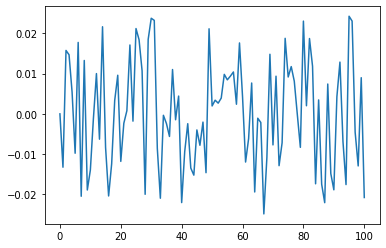

In [55]:
random_walk = [0]
momentum = 0.95
for i in range(100):
    new_pos = random_walk[0] * momentum + (random.random()-0.5) * (1-momentum)
    random_walk.append(new_pos)
    
plt.plot(random_walk)

In [79]:
orig = normalized_vec_to_orig(ds_contour, mean_pitch=69)
print(orig.shape)
audio = generate_sine_wav(orig, frame_rate=10)
ipd.Audio(audio, rate=44100)
# plt.plot(orig)
# plt.plot(aug)

(86,)


In [68]:
aug.shape

(857, 2)

In [320]:
melody_dict = random.sample(melody_set, 1)
melody_array = melody_dict_to_array(melody_dict[0])
melody_ds = downsample_with_float(melody_array)
orig = normalized_vec_to_orig(melody_ds, mean_pitch=69)
audio = generate_sine_wav(orig, frame_rate=10)
ipd.Audio(audio, rate=44100)

In [334]:
aug_melody

array([[1.04884097, 1.        ],
       [1.06018344, 1.        ],
       [1.36656776, 1.        ],
       [1.30983224, 1.        ],
       [1.35522094, 1.        ],
       [1.00344044, 1.        ],
       [0.99209524, 1.        ],
       [0.96940225, 1.        ],
       [0.62896302, 1.        ],
       [0.62896302, 1.        ],
       [0.62896302, 1.        ],
       [0.62896302, 1.        ],
       [0.65165845, 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.45874957, 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.62896302, 1.        ],
       [0.61761446, 1.        ],
       [0.66301839, 1.        ],
       [0.62896302, 1.        ],
       [0.66301839, 1.        ],
       [0.98074511, 1.        ],
       [0.98074511, 1.        ],
       [0.95805475, 1.        ],
       [0.98074511, 1.        ],
       [0.96940225, 1.        ],
       [0.96940225, 1.        ],
       [0.

In [201]:
import soundfile as sf
sf.write('test.wav', audio, 44100)

In [333]:
aug_melody = make_augmented_melody(melody_array)
aug = normalized_vec_to_orig(aug_melody, mean_pitch=69)
audio = generate_sine_wav(aug, frame_rate=10) 
ipd.Audio(audio, rate=44100)

[[1.04439487 1.        ]
 [1.05571172 1.        ]
 [1.36140416 1.        ]
 [1.30479677 1.        ]
 [1.35008297 1.        ]
 [0.99909687 1.        ]
 [0.98777728 1.        ]
 [0.96513554 1.        ]
 [0.62546509 1.        ]
 [0.62546509 1.        ]
 [0.62546509 1.        ]
 [0.62546509 1.        ]
 [0.64810927 1.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.45563602 1.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.62546509 1.        ]
 [0.61414216 1.        ]
 [0.65944355 1.        ]
 [0.62546509 1.        ]
 [0.65944355 1.        ]
 [0.97645278 1.        ]
 [0.97645278 1.        ]
 [0.95381367 1.        ]
 [0.97645278 1.        ]
 [0.96513554 1.        ]
 [0.96513554 1.        ]
 [0.98777728 1.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]


In [327]:
aug_melody

array([[ 0.07949346,  0.        ],
       [-0.25654722,  1.        ],
       [-0.25654722,  1.        ],
       [-0.05363919,  1.        ],
       [ 0.70159324,  1.        ],
       [ 0.71286012,  1.        ],
       [ 0.88194209,  1.        ],
       [ 0.94957411,  1.        ],
       [ 1.03975001,  1.        ],
       [ 0.76922352,  1.        ],
       [ 0.64522565,  1.        ],
       [ 0.65649526,  1.        ],
       [ 0.31834175,  1.        ],
       [ 0.28451333,  1.        ],
       [ 0.28430615,  1.        ],
       [ 0.28430615,  1.        ],
       [ 0.29557857,  1.        ],
       [ 0.29557857,  1.        ],
       [ 0.07928628,  0.        ],
       [ 0.07928628,  0.        ],
       [ 0.11522699,  1.        ],
       [ 0.07928628,  0.        ],
       [ 0.07928628,  0.        ],
       [ 0.28430615,  1.        ],
       [ 0.27303322,  1.        ],
       [ 0.30685034,  1.        ],
       [ 0.26177341,  1.        ],
       [ 0.35194126,  1.        ],
       [ 0.48613806,

In [256]:
from pathlib import Path
import os
save_path = Path('aug_test/')
if not save_path.exists():
    os.mkdir(save_path)
for melody_dict in melody_set:
    melody_array = melody_dict_to_array(melody_dict)
    melody_ds = downsample_with_float(melody_array)
    orig = normalized_vec_to_orig(melody_ds, mean_pitch=69)
    audio = generate_sine_wav(orig, frame_rate=10)
    
    song_id = str(melody_dict['song_id'])
    frame_pos = str(melody_dict['frame_pos'])
    sf.write(save_path / '{}_{}_orig.wav'.format(song_id, frame_pos), audio, 44100)
    
    for i in range(5):
        aug_melody = make_augmented_melody(melody_array)
        aug = normalized_vec_to_orig(aug_melody, mean_pitch=69)
        aug_audio = generate_sine_wav(aug, frame_rate=10) 
        sf.write(save_path / '{}_{}_aug_{}.wav'.format(song_id, frame_pos, i), aug_audio, 44100)

[0.006064891815185547, 0.0012650489807128906, 1.52587890625e-05, 3.314018249511719e-05]
[0.006736040115356445, 0.0009975433349609375, 1.9073486328125e-05, 3.147125244140625e-05]
[1.621246337890625e-05, 0.008215188980102539, 0.00012421607971191406, 0.0003275871276855469, 0.00021791458129882812, 0.0002014636993408203]
[0.005434751510620117, 0.0008535385131835938, 1.3113021850585938e-05, 2.5987625122070312e-05]
[1.6450881958007812e-05, 0.00671839714050293, 9.322166442871094e-05, 0.0002617835998535156, 0.0001571178436279297, 0.00012040138244628906]
[0.012713909149169922, 0.002351045608520508, 2.86102294921875e-05, 7.748603820800781e-05]
[2.1696090698242188e-05, 0.02198648452758789, 0.00014853477478027344, 0.0003609657287597656, 0.00026106834411621094, 0.0002803802490234375]
[0.006154298782348633, 0.0012295246124267578, 1.5497207641601562e-05, 3.504753112792969e-05]
[1.5497207641601562e-05, 0.0514378547668457, 0.00017142295837402344, 0.0003211498260498047, 0.00025773048400878906, 0.00026321

KeyboardInterrupt: 

In [207]:
vars(save_path)

TypeError: vars() argument must have __dict__ attribute

PosixPath('aug_test')